# More GIS in Python

# 1 Introduction

This exercise is designed to follow on from our [Introduction to GIS in Python course](https://github.com/ONSgeo/Introduction_to_GIS_in_Python). We will use both the data from the previous course and some new sources in this walkthrough.

# 1.1 Aims

The aim for this course is to build confidence in using some of the basic spatial analysis tools and develop geospatial thinking - the way of thinking about spatial problems, which often involves chaining a number of simple tools together, to effectively answer questions about where.

### By the end of the course you will:

* be comfortable using simple geospatial operations like buffers, intersections etc.
* be able to provide summary statistics for areas
* understand more about joins, and what happens when they go wrong
* understand about network analysis and how it can improve the accuracy of some analyses
* be more comfortable troubleshooting some common error messages
* complete a piece of spatial analysis and be able to present it

# 2 Getting Started

## 2.1 Set up

* Open the Notebook **'More GIS in Python Workbook'**
* As you make your way through the guided exercises on this Notebook, you may use the Workbook as your workspace.
* Read through each exercise and try out your solution on the Template Notebook and check your output against the solution on this Notebook.

## 2.2 Working directory structure

It’s a good habit to keep your working directory in order.

In this exercise we’ll be using the following structure in our project directory:
* data
    * csv
    * img
    * shp
* output
    * maps
    

If you don’t already have this set up, take some time to do it now.

# 2.3 Install & load Python libraries

As with every Python Project, make sure you have all required packages installed and loaded into your Notebook.

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import janitor as pj
import matplotlib.pyplot as plt
import fiona as fn
from matplotlib_scalebar.scalebar import ScaleBar

## 2.4 Data Sources

As well as the data from Introduction to GIS in Python we will be using a few new data sources during this work:

* [Ordnance Survey Open Greenspace](https://osdatahub.os.uk/downloads/open/OpenGreenspace?_ga=2.76356949.1574366512.1629803242-2038235350.1629803242)
* A geopackage of London fire station locations (provided in the repo)
* a csv of missing pet reports (a toy dataset provided in the repo)
We have also provided you with a geopackage of the data and layers that were created in ‘Introduction to GIS in Python’ which may be useful in this walkthrough too - it’s called **"intro_to_gis_files.gpkg"**.

## 2.5 Analysis Questions and Aims

During this analysis we’ll aim to answer the following questions:

* How is greenspace distributed in each UTLA in London?
* How many animals are rescued in each London greenspace?
* Is the fire station coverage in the area adequate to rescue all animals?
* If not, how far away from the area covered by fire stations is each lost pet?
* Produce maps and data to produce a mini analysis notebook/report/presentation showing the results of your analysis.

# 3 Analysis

## 3.1 Preparing OS Open Greenspace

As a first step we need to download the greenspace data for our analysis.

Download tiles TQ and TL from the [Ordnance Survey Open Greenspace dataset](https://osdatahub.os.uk/downloads/open/OpenGreenspace?_ga=2.76356949.1574366512.1629803242-2038235350.1629803242) as a shapefile, unzip them and move them into the data/shp folder in your working directory.

Tip: Don’t forget that one shapefile requires 3 consituent files to be valid (shp, shx, dbf), and may have other associated files too. Wikipedia has a comprehensive list of all potential extensions. Make sure all files have the same name and are stored in the same place otherwise your shapefile won’t work!

We now need to load the two shapefiles in and merge them into one feature for subsequent analysis.

You already know how to load in shapefiles so go ahead and do that.



In [2]:
TL = gpd.read_file(r'D:\2021\Spatial\more-GIS-in-Python\data\TL_GreenspaceSite.shp')

In [3]:
TQ = gpd.read_file(r'D:\2021\Spatial\more-GIS-in-Python\data\TQ_GreenspaceSite.shp')

Now let’s make a quick plot to see what we just loaded in.

<AxesSubplot:>

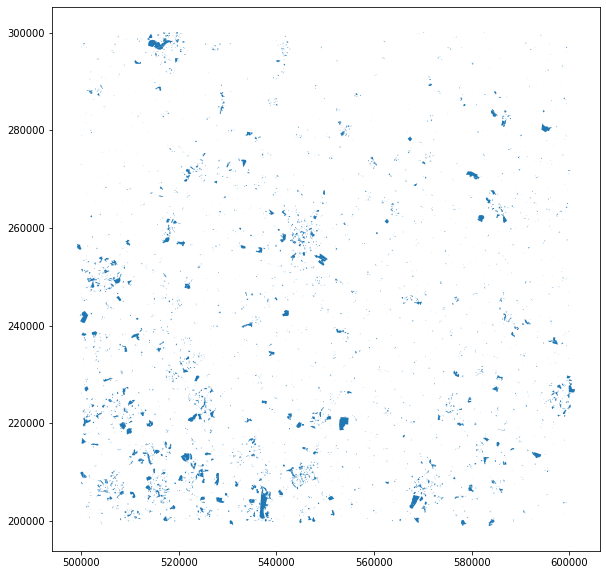

In [4]:
TL.plot(figsize = (10,10))

When we inspect the head we can see that there are 6 fields in this dataset. Note that one field is the geometry field, which is where the spatial aspect of each object is stored. The ‘function’ column might be useful in our analysis later.

In [5]:
TL.head()

,id,function,distName1,distName2,distName3,distName4,geometry
0,C72D736F-0E9C-0B9F-E053-A03BA40AF257,Religious Grounds,Holy Cross Church,None,None,None,"POLYGON Z ((595908.000 297525.140 0.000, 59590..."
1,C72D736F-11B4-0B9F-E053-A03BA40AF257,Religious Grounds,St Botolph's Church,None,None,None,"POLYGON Z ((596186.700 295604.110 0.000, 59619..."
2,C72D736F-0FB0-0B9F-E053-A03BA40AF257,Cemetery,None,None,None,None,"POLYGON Z ((598866.250 297637.950 0.000, 59886..."
3,C72D736F-101C-0B9F-E053-A03BA40AF257,Religious Grounds,St Peter's Church,None,None,None,"POLYGON Z ((599025.150 297068.970 0.000, 59902..."
4,C72D733E-95F5-0B9F-E053-A03BA40AF257,Play Space,None,None,None,None,"POLYGON Z ((599365.240 296952.550 0.000, 59932..."


You might have noticed that the geometry type is multipolygon, which is something we haven’t come across yet. A multipoloygon is an object (row) in the dataset which can be comprised of a number of distinct polygons. Here’s an example:

<AxesSubplot:>

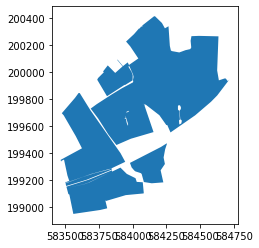

In [6]:
#in this code we combine the pandas filter function with matplotlib to plot one feature from the TL dataset
TL.loc[TL['id']== 'C72D73AB-9E4A-0B9F-E053-A03BA40AF257'].plot()

Now we’ve had a quick look at our data we need to get it ready for analysis. We will merge the two greenspace tiles into one object in our Notebook so we can work with it more later.

You have likely seen a version of the Venn diagrams below in the context of joining data. In this context, they show methods for working with poygon geometries. Looking at this diagram you might think that **Union** is what we want to join our two greenspace tiles together, but it’s not! **Union**  dissolves all the polygons in the layers into one huge multipart polygon. We want to keep our distinct greenspace polygons so we’ll go down a different route instead. However, keep the diagram below in mind because it can be very useful and you’ll stumble across it later too.

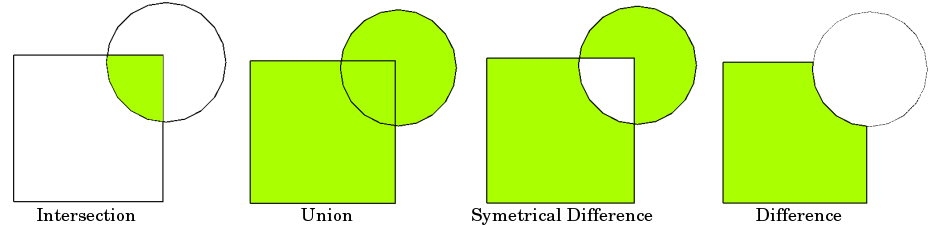

*Image from Geopandas documentation.*

As each multipart polygon in our dataset is represented as one row, joining the two datasets together is simple

In [7]:
tiles_combined = [TL,TQ]

In [8]:
greenspace = pd.concat(tiles_combined)

There are a couple of sanity checks you can do here to make sure that went well - check the number of objects add up properly (8805+19932 = 28737!) and plot a map to check our object (we can clearly see London and part of the SE below).

<AxesSubplot:>

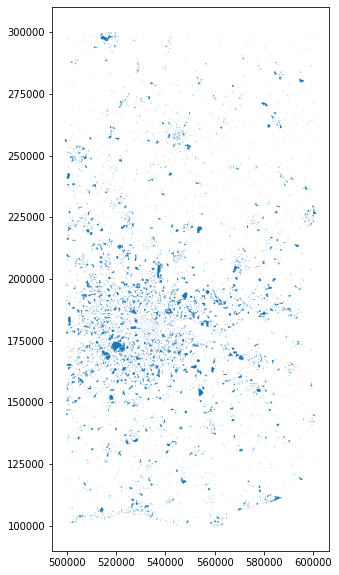

In [9]:
greenspace.plot(figsize =(10,10))

Now we’ll crop our greenspace layer to the extent of London - this layer is one we prepared during Introduction to GIS in Python’ so bring it back in from your code or import it from the **"intro_to_gis_files.gpkg"** file we’ve provided for you. If you’ve not come across a geopackage before don’t worry - a geopackage is a SQLite file, essentially a mini database which can hold multiple layers (both spatial and tabular).

Use `fiona.listlayers()` to find out what layers are available in your geopackage.

In [10]:
gpkg = r'D:\2021\Spatial\more-GIS-in-Python\data\intro_to_gis_files.gpkg'
layers = fn.listlayers(gpkg)

In [11]:
layers

['London_MSOAs_and_incidents_BSC',
 'MSOA_2011_BSC_London',
 'MSOA_2011_BFE_London',
 'london_fire_brigade_incidents',
 'UTLA_2019_London_dissolved',
 'UTLA_2019_London']

In [12]:
london_boundary = gpd.read_file(r'D:\2021\Spatial\more-GIS-in-Python\data\intro_to_gis_files.gpkg', layer = 'UTLA_2019_London_dissolved')

In [13]:
greenspace_london = gpd.overlay(greenspace,london_boundary, how='intersection')

<ipython-input-13-c11061aabe0a>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:27700
Right CRS: EPSG:4326

  greenspace_london = gpd.overlay(greenspace,london_boundary, how='intersection')


Oh no! We have an error.

This error says CRS mismatch between the CRS of left geometries and the CRS of right geometries. - in other words, the coordinate reference system (CRS) of the two input layers is not the same. It’s always good practice to check your coordinate reference systems are the same prior to undertaking spatial operations. You can check the CRS of a layer with **`.crs`** and you check two layers have the same CRS with **`gdf1.crs == gdf2.crs`**.

If you check the two layers we have now you’ll find greenspace is provided in British National Grid (EPSG code: 27700) and **london_boundary** is in WGS84 (EPSG code: 4326). You’ll come across these two CRSs very commonly in UK focused work.

To get rid of the error message you’ll need to transform one of your layers so it’s in the same CRS as the other. However, which one should you transform? Well, if you remember back to [Practical Geography for Statistics](https://onsgeo.github.io/geospatial-training/docs/practical_geog_and_stats#locating-spatial-data), we said that that WGS84 is a geographic coordinate reference system (which means it represents positions on the 3D Earth using longitude and latitude) whereas British National Grid is a projected coordinate reference system (which represents positions as if they were presented on a flat map using meters). Doing spatial operations is more simple and accurate on projected coordinate reference systems so in this instance we’ll transform the WGS84 layer to British National Grid.

It’s worth noting here that all CRS transformations come with some degree of error so try to avoid unnecessary transformations, and if you’re using an unfamiliar CRS take a look into the accuracy of the transformation so that you understand the potential positional error you are introducing into your analysis.

So, reproject **london_boundary** into British National Grid.

In [14]:
london_boundary = london_boundary.to_crs(27700)

In [15]:
greenspace.crs == london_boundary.crs

True

Now our layers are in the same CRS!

In [16]:
greenspace_london = gpd.overlay(greenspace,london_boundary, how='intersection')

Now you can see your greenspace layer has been clipped to the London boundary. We’re ready to get on with some analysis.

<AxesSubplot:>

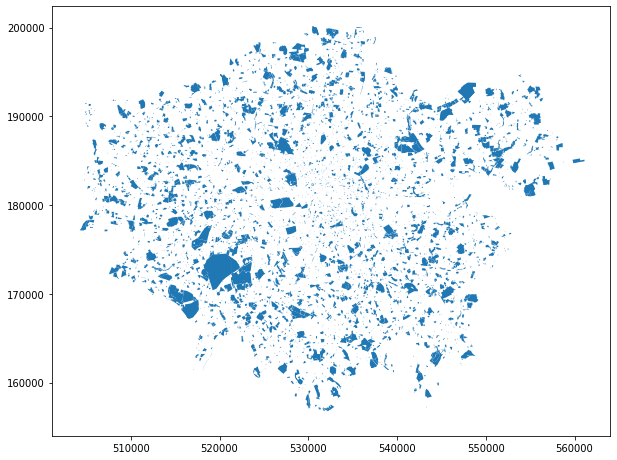

In [17]:
greenspace_london.plot(figsize = (10,10))

# Calculating the Area of Greenspaces

Before we calculate the area of each greenspace polygon we need to intersect the greenspace layer with the UTLA boundaries, so we divide greenspace polygons where they cross UTLA boundaries.

We’ve already covered how to do this so see if you can:
* load in the Upper Tier Local Authority boundaries (UTLAs) from **"intro_to_gis_files.gpkg"**
* check the CRS and transform it if necessary
* intersect the greenspace and UTLA layers

In [18]:
utla = gpd.read_file(r'D:\2021\Spatial\more-GIS-in-Python\data\intro_to_gis_files.gpkg', layer = 'UTLA_2019_London')

In [19]:
utla.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [20]:
utla = utla.to_crs(27700)

In [21]:
greenspace_utla_intersection = gpd.overlay(utla, greenspace, how ='intersection')

If you take a glimpse at the intersection output you’ll see that for each greenspace polygon, there are now attributes about the UTLA it falls within - we’ve done a spatial join here. We’ve also split greenspace polygons which cover more than one UTLA along the UTLA boundary.

In [22]:
greenspace_utla_intersection.head()

,ctyua19cd,ctyua19nm,id,function,distName1,distName2,distName3,distName4,geometry
0,E09000001,City of London,C72D73B6-7DBE-0B9F-E053-A03BA40AF257,Public Park Or Garden,Tower Gardens,None,None,None,"POLYGON Z ((533640.866 180742.011 0.000, 53363..."
1,E09000030,Tower Hamlets,C72D73B6-7DBE-0B9F-E053-A03BA40AF257,Public Park Or Garden,Tower Gardens,None,None,None,"POLYGON Z ((533631.050 180772.450 0.000, 53363..."
2,E09000001,City of London,C72D74C6-A4B8-0B9F-E053-A03BA40AF257,Public Park Or Garden,Seething Lane Garden,None,None,None,"POLYGON Z ((533400.620 180755.410 0.000, 53339..."
3,E09000001,City of London,C72D73BF-E63C-0B9F-E053-A03BA40AF257,Public Park Or Garden,King George's Field,None,None,None,"POLYGON Z ((533712.000 180914.100 0.000, 53369..."
4,E09000001,City of London,C72D73BF-DEC2-0B9F-E053-A03BA40AF257,Public Park Or Garden,Saint Swithun's Church Garden,None,None,None,"POLYGON Z ((532647.000 180945.800 0.000, 53265..."


We will shortly calculate summary statistics about greenspace distribution across London. Before we do that you’ll notice we don’t have any attributes for area; we can calculate them using .area One thing to be aware of with .area is that the areas calculated come with units - they are based on the units of the CRS of the layer - so for British National Grid they come in m^2. You can convert them into other units by multiplying the area column with the units you want to convert it to.

In [23]:
greenspace_utla_intersection['area'] = greenspace_utla_intersection.area

In [24]:
greenspace_utla_intersection.head()

,ctyua19cd,ctyua19nm,id,function,distName1,distName2,distName3,distName4,geometry,area
0,E09000001,City of London,C72D73B6-7DBE-0B9F-E053-A03BA40AF257,Public Park Or Garden,Tower Gardens,None,None,None,"POLYGON Z ((533640.866 180742.011 0.000, 53363...",1000.020599
1,E09000030,Tower Hamlets,C72D73B6-7DBE-0B9F-E053-A03BA40AF257,Public Park Or Garden,Tower Gardens,None,None,None,"POLYGON Z ((533631.050 180772.450 0.000, 53363...",719.659201
2,E09000001,City of London,C72D74C6-A4B8-0B9F-E053-A03BA40AF257,Public Park Or Garden,Seething Lane Garden,None,None,None,"POLYGON Z ((533400.620 180755.410 0.000, 53339...",1112.564600
3,E09000001,City of London,C72D73BF-E63C-0B9F-E053-A03BA40AF257,Public Park Or Garden,King George's Field,None,None,None,"POLYGON Z ((533712.000 180914.100 0.000, 53369...",666.598100
4,E09000001,City of London,C72D73BF-DEC2-0B9F-E053-A03BA40AF257,Public Park Or Garden,Saint Swithun's Church Garden,None,None,None,"POLYGON Z ((532647.000 180945.800 0.000, 53265...",273.239700


In [25]:
greenspace_utla_intersection['ha'] = greenspace_utla_intersection.area*0.0001

In [26]:
greenspace_utla_intersection.head()

,ctyua19cd,ctyua19nm,id,function,distName1,distName2,distName3,distName4,geometry,area,ha
0,E09000001,City of London,C72D73B6-7DBE-0B9F-E053-A03BA40AF257,Public Park Or Garden,Tower Gardens,None,None,None,"POLYGON Z ((533640.866 180742.011 0.000, 53363...",1000.020599,0.100002
1,E09000030,Tower Hamlets,C72D73B6-7DBE-0B9F-E053-A03BA40AF257,Public Park Or Garden,Tower Gardens,None,None,None,"POLYGON Z ((533631.050 180772.450 0.000, 53363...",719.659201,0.071966
2,E09000001,City of London,C72D74C6-A4B8-0B9F-E053-A03BA40AF257,Public Park Or Garden,Seething Lane Garden,None,None,None,"POLYGON Z ((533400.620 180755.410 0.000, 53339...",1112.564600,0.111256
3,E09000001,City of London,C72D73BF-E63C-0B9F-E053-A03BA40AF257,Public Park Or Garden,King George's Field,None,None,None,"POLYGON Z ((533712.000 180914.100 0.000, 53369...",666.598100,0.066660
4,E09000001,City of London,C72D73BF-DEC2-0B9F-E053-A03BA40AF257,Public Park Or Garden,Saint Swithun's Church Garden,None,None,None,"POLYGON Z ((532647.000 180945.800 0.000, 53265...",273.239700,0.027324


# Calculate Greenspace Summary Statistics by Local Authority
We’re now going to produce some summary stats:
* total area of greenspace per UTLA
* number of greenspace areas per UTLA

We can use pandas tools to calculate these statistics, so you should be comfortable with these operations.

However, before we start, it’s important that we drop the geometry from the data frame using the **`.drop()`** function which allows us to stop using the spatial aspects of this data frame and work with it like a normal, non-spatial data frame.

In [27]:
utla_greenspace_stats = greenspace_utla_intersection.drop(columns = ['geometry'])

In [28]:
utla_greenspace_stats_df = utla_greenspace_stats.groupby('ctyua19cd').ha.agg(['sum','count']).reset_index().rename(columns={'sum' : 'total_greenspace_ha','count':'number_of_greenspaces'})

In [29]:
utla_greenspace_stats.head()

,ctyua19cd,ctyua19nm,id,function,distName1,distName2,distName3,distName4,area,ha
0,E09000001,City of London,C72D73B6-7DBE-0B9F-E053-A03BA40AF257,Public Park Or Garden,Tower Gardens,None,None,None,1000.020599,0.100002
1,E09000030,Tower Hamlets,C72D73B6-7DBE-0B9F-E053-A03BA40AF257,Public Park Or Garden,Tower Gardens,None,None,None,719.659201,0.071966
2,E09000001,City of London,C72D74C6-A4B8-0B9F-E053-A03BA40AF257,Public Park Or Garden,Seething Lane Garden,None,None,None,1112.564600,0.111256
3,E09000001,City of London,C72D73BF-E63C-0B9F-E053-A03BA40AF257,Public Park Or Garden,King George's Field,None,None,None,666.598100,0.066660
4,E09000001,City of London,C72D73BF-DEC2-0B9F-E053-A03BA40AF257,Public Park Or Garden,Saint Swithun's Church Garden,None,None,None,273.239700,0.027324


In [30]:
utla_greenspace_stats_df.head()

,ctyua19cd,total_greenspace_ha,number_of_greenspaces
0,E09000001,6.248149,22
1,E09000002,590.677370,211
2,E09000003,1383.061195,468
3,E09000004,548.291614,305
4,E09000005,541.121742,261


# Exercise
See if you can calculate how many pet rescue incidents happened in each greenspace by using your knowledge of Pandas and the spatial operations you’ve seen so far. How about plotting a map to illustrate them? If you finish quickly, try out some other summary statistics that might be useful for your report.

# Missing Pet Reports
Now we’re going to take a look at some missing pet reports (a reminder this is a toy dataset). Load it in and take a look through the data. While you’re looking, think about what makes this data spatial data, what you’ll need to do to it to make it more useful, and how you might make use of this data.

In [31]:
lost_pets = pd.read_csv(r'D:\2021\Spatial\more-GIS-in-Python\data\csv\lost_pet_reports.csv')

In [32]:
lost_pets.head()

,id,easting,northing,ctyua19cd,ctyua19nm,animal,pet_found
0,0,551715,187663,E09000016,Havering,dog,no
1,1,538294,180697,E09000030,Tower Hamlets,dog,yes
2,2,521723,186045,E09000005,Brent,cat,yes
3,3,532297,191492,E09000014,Haringey,cat,yes
4,4,538327,161351,E09000008,Croydon,cat,no


So, let’s think about this data:

* it’s got coordinates which means we know the position of each individual point - this is the spatial aspect
* we also have a statistical geography code **(ctyua19cd)** which is another piece of spatial information
* there’s no metadata so we’re not sure what CRS the coordinates are in. However, the numbers are within the normal range of British National Grid and given this is data for London it seems a sensible choice. So, we’ll try it out and see whether it plots in the right place by verifying this against other location data we have (like the ctyua19nm column).
* to make this data a useful format we’ll need to convert the easting and northings into point geometries
* there are no NAs within the dataset
* and we’ll take a look at some ideas for analysing this data later on!

Before we dive into some analysis let’s quickly make some summary stats which we can use to understand our data a bit more, and also to use in our report later. For each area, we’ll find the count of each animal type and calculate this as a percentage of total lost animals.

In [33]:
lost_pets_stats = lost_pets.groupby(['ctyua19cd', 'animal']).animal.agg(['count']).reset_index().rename(columns={'count' : 'count_lost_pets'})

In [34]:
lost_pets_stats.head()

,ctyua19cd,animal,count_lost_pets
0,E09000001,cat,1
1,E09000003,bird,1
2,E09000003,cat,7
3,E09000003,dog,12
4,E09000003,goat,1


In [35]:
lost_pets_counts = lost_pets.groupby('ctyua19cd').animal.agg(['count']).reset_index().rename(columns={'count':'total_pets'})

In [36]:
lost_pets_counts.head()

,ctyua19cd,total_pets
0,E09000001,1
1,E09000003,26
2,E09000004,17
3,E09000005,14
4,E09000006,54


In [37]:
lost_pets_stats = pd.merge(lost_pets_stats,lost_pets_counts, how ='left', on ='ctyua19cd')

In [38]:
lost_pets_stats.head()

,ctyua19cd,animal,count_lost_pets,total_pets
0,E09000001,cat,1,1
1,E09000003,bird,1,26
2,E09000003,cat,7,26
3,E09000003,dog,12,26
4,E09000003,goat,1,26


In [39]:
lost_pets_stats['lost_pets_pct'] = (lost_pets_stats.count_lost_pets/lost_pets_stats.total_pets)*100

In [40]:
lost_pets_stats.head()

,ctyua19cd,animal,count_lost_pets,total_pets,lost_pets_pct
0,E09000001,cat,1,1,100.000000
1,E09000003,bird,1,26,3.846154
2,E09000003,cat,7,26,26.923077
3,E09000003,dog,12,26,46.153846
4,E09000003,goat,1,26,3.846154


Now let’s join the dogs to the UTLA boundaries and plot a map.

In [41]:
utla_lost_pet_stats  = pd.merge(utla, lost_pets_stats.loc[lost_pets_stats['animal']== 'dog'], how = 'left',on = 'ctyua19cd')

Take a look at the data - did everything join successfully?

In [42]:
utla_lost_pet_stats.head()

,ctyua19cd,ctyua19nm,geometry,animal,count_lost_pets,total_pets,lost_pets_pct
0,E09000001,City of London,"POLYGON ((532140.297 182191.897, 532141.501 18...",NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,"POLYGON ((548881.803 190803.002, 548881.201 19...",NaN,NaN,NaN,NaN
2,E09000003,Barnet,"POLYGON ((524579.898 198355.200, 524594.302 19...",dog,12.0,26.0,46.153846
3,E09000004,Bexley,"POLYGON ((549853.302 181077.696, 549999.998 18...",dog,5.0,17.0,29.411765
4,E09000005,Brent,"POLYGON ((520284.699 190241.403, 520319.402 19...",dog,7.0,14.0,50.000000


Hmm… we have animals in Barking and Dagenham in our summary stats so why haven’t they joined? Take a look at the data and see if you can spot it.

In [43]:
utla_lost_pet_stats[utla_lost_pet_stats.isna().any(axis=1)]

,ctyua19cd,ctyua19nm,geometry,animal,count_lost_pets,total_pets,lost_pets_pct
0,E09000001,City of London,"POLYGON ((532140.297 182191.897, 532141.501 18...",NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,"POLYGON ((548881.803 190803.002, 548881.201 19...",NaN,NaN,NaN,NaN


Filtering with the **`.isna()`** function to check your joins can be a good way to test to see which rows haven’t joined. In this case we have 2 rows which haven’t joined. We don’t expect a join for City of London because there were no lost dogs reported there. However, there should have been a join with Barking and Dagenham.

If we go further by using the **`.isin()`** function with the tilde, we can find the reason why our join didnt work.

In [44]:
geocodes_in_utla = utla.ctyua19cd.unique()
not_found_utla_geocodes = lost_pets_stats[~lost_pets_stats['ctyua19cd'].isin(geocodes_in_utla)]
not_found_utla_geocodes

,ctyua19cd,animal,count_lost_pets,total_pets,lost_pets_pct
143,E09000042,cat,5,10,50.0
144,E09000042,dog,4,10,40.0
145,E09000042,snake,1,10,10.0


In [45]:
geocodes_in_lps = lost_pets_stats.ctyua19cd.unique()
not_found_lps_geocodes = utla[~utla['ctyua19cd'].isin(geocodes_in_lps)]
not_found_lps_geocodes

,ctyua19cd,ctyua19nm,geometry
1,E09000002,Barking and Dagenham,"POLYGON ((548881.803 190803.002, 548881.201 19..."


That is because, if you take a look you’ll see there’s an incorrect code - “E09000042”. You can search the code on the ONS Linked Data Portal to see that it doesn’t correspond to a geography. With some more investigation (eg. plotting maps) you can draw the conclusion that this UTLA has been incorrectly labeled. So, we’ll correct it and rerun our previous code.

Replacing the incorrect code

In [46]:
lost_pets = lost_pets.replace("E09000042", "E09000002")

#### Re-running a few bits of our code to make the corrections on the lost_pets dataframe

In [47]:
lost_pets_stats = lost_pets.groupby(['ctyua19cd', 'animal']).animal.agg(['count']).reset_index().rename(columns={'count' : 'count_lost_pets'})

In [48]:
lost_pets_stats.head()

,ctyua19cd,animal,count_lost_pets
0,E09000001,cat,1
1,E09000002,cat,5
2,E09000002,dog,4
3,E09000002,snake,1
4,E09000003,bird,1


In [49]:
lost_pets_counts = lost_pets.groupby('ctyua19cd').animal.agg(['count']).reset_index().rename(columns={'count':'total_pets'})

In [50]:
lost_pets_counts.head()

,ctyua19cd,total_pets
0,E09000001,1
1,E09000002,10
2,E09000003,26
3,E09000004,17
4,E09000005,14


In [51]:
lost_pets_stats = pd.merge(lost_pets_stats,lost_pets_counts, how ='left', on ='ctyua19cd')

In [52]:
lost_pets_stats.head()

,ctyua19cd,animal,count_lost_pets,total_pets
0,E09000001,cat,1,1
1,E09000002,cat,5,10
2,E09000002,dog,4,10
3,E09000002,snake,1,10
4,E09000003,bird,1,26


In [53]:
lost_pets_stats['lost_pets_pct'] = (lost_pets_stats.count_lost_pets/lost_pets_stats.total_pets)*100

In [54]:
lost_pets_counts.head()

,ctyua19cd,total_pets
0,E09000001,1
1,E09000002,10
2,E09000003,26
3,E09000004,17
4,E09000005,14


In [55]:
lost_pets_stats.head()

,ctyua19cd,animal,count_lost_pets,total_pets,lost_pets_pct
0,E09000001,cat,1,1,100.000000
1,E09000002,cat,5,10,50.000000
2,E09000002,dog,4,10,40.000000
3,E09000002,snake,1,10,10.000000
4,E09000003,bird,1,26,3.846154


In [56]:
utla_lost_pet_stats  = pd.merge(utla, lost_pets_stats.loc[lost_pets_stats['animal']== 'dog'], how = 'left',on = 'ctyua19cd')

In [57]:
utla_lost_pet_stats.head()

,ctyua19cd,ctyua19nm,geometry,animal,count_lost_pets,total_pets,lost_pets_pct
0,E09000001,City of London,"POLYGON ((532140.297 182191.897, 532141.501 18...",NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,"POLYGON ((548881.803 190803.002, 548881.201 19...",dog,4.0,10.0,40.000000
2,E09000003,Barnet,"POLYGON ((524579.898 198355.200, 524594.302 19...",dog,12.0,26.0,46.153846
3,E09000004,Bexley,"POLYGON ((549853.302 181077.696, 549999.998 18...",dog,5.0,17.0,29.411765
4,E09000005,Brent,"POLYGON ((520284.699 190241.403, 520319.402 19...",dog,7.0,14.0,50.000000


In [58]:
utla_lost_pet_stats[utla_lost_pet_stats.isna().any(axis=1)]

,ctyua19cd,ctyua19nm,geometry,animal,count_lost_pets,total_pets,lost_pets_pct
0,E09000001,City of London,"POLYGON ((532140.297 182191.897, 532141.501 18...",NaN,NaN,NaN,NaN


Now when we run our **`.isin()`** function we do not expect to get any output if the errors in the data have successfully been dealt with. Lets go ahead and check!

In [59]:
geocodes_in_utla = utla.ctyua19cd.unique()
not_found_utla_geocodes = lost_pets_stats[~lost_pets_stats['ctyua19cd'].isin(geocodes_in_utla)]
not_found_utla_geocodes

,ctyua19cd,animal,count_lost_pets,total_pets,lost_pets_pct


In [60]:
geocodes_in_lps = lost_pets_stats.ctyua19cd.unique()
not_found_lps_geocodes = utla[~utla['ctyua19cd'].isin(geocodes_in_lps)]
not_found_lps_geocodes

,ctyua19cd,ctyua19nm,geometry


Time to map out data!

Text(0.5, 1.0, 'Lost dogs reported in London, percent of total reports')

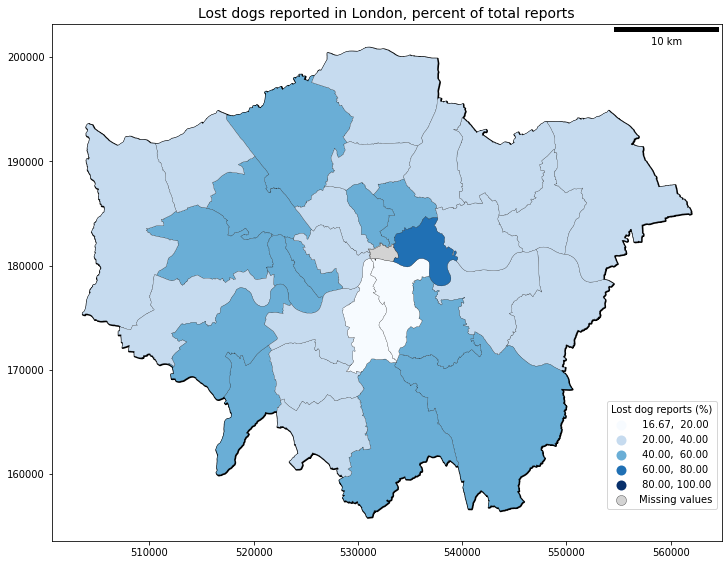

In [61]:
f, ax = plt.subplots(figsize=(12,10))
london_boundary.plot(ax=ax, color='white', edgecolor='black', linewidth = 2)
utla_lost_pet_stats.plot(ax=ax, column='lost_pets_pct', cmap='Blues', edgecolor = 'k', 
              linewidth = 0.2, scheme="User_Defined", legend=True,
              classification_kwds={'bins':[20, 40, 60, 80, 100]},
              missing_kwds={"color": "lightgrey", "edgecolor": "black", "linewidth": 0.3,"label": "Missing values",},
              legend_kwds={'bbox_to_anchor':(1,0.28), 'title':'Lost dog reports (%)'})
ax.add_artist(ScaleBar(1))
plt.title('Lost dogs reported in London, percent of total reports', size = 14)

Now, let’s convert our lost pets layer to an sf object ready for our next piece of analysis.

In [62]:
lost_pets_gdf = gpd.GeoDataFrame(
    lost_pets, geometry=gpd.points_from_xy(lost_pets.easting, lost_pets.northing))
lost_pets_gdf = lost_pets_gdf.set_crs(27700)

In [63]:
lost_pets_gdf.head()

,id,easting,northing,ctyua19cd,ctyua19nm,animal,pet_found,geometry
0,0,551715,187663,E09000016,Havering,dog,no,POINT (551715.000 187663.000)
1,1,538294,180697,E09000030,Tower Hamlets,dog,yes,POINT (538294.000 180697.000)
2,2,521723,186045,E09000005,Brent,cat,yes,POINT (521723.000 186045.000)
3,3,532297,191492,E09000014,Haringey,cat,yes,POINT (532297.000 191492.000)
4,4,538327,161351,E09000008,Croydon,cat,no,POINT (538327.000 161351.000)


The **`.explore()`** will only work if you have Geopandas v10.0 later

In [64]:
lost_pets_gdf.explore()

# Exercise
Investigate the data more and practice plotting maps using **`.plot()`** and **`.explore()`**

# Fire Stations - data preparation
Introducing our last dataset for this piece of work - the location of all London Fire Stations. We’re going to use this data to understand how the London Fire Brigade cover incidents happening in the city.

We have a csv list of fire stations - let’s load it in and take a look.

In [65]:
stations = pd.read_csv(r'D:\2021\Spatial\more-GIS-in-Python\data\csv\london_fire_brigade_stations.csv')

In [66]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Borough       102 non-null    object
 1   Station Name  102 non-null    object
 2   Address       102 non-null    object
dtypes: object(3)
memory usage: 2.5+ KB


In [67]:
stations.head()

,Borough,Station Name,Address
0,Barking and Dagenham,Barking,"Alfred's Way, IG11 0BB"
1,Barking and Dagenham,Dagenham,"70 Rainham Road North, Dagenham, RM10 7ES"
2,Barnet,Barnet,"144 Station Road, EN5 1TE"
3,Barnet,Finchley,"227 Long Lane, N3 2RP"
4,Barnet,Hendon,"91 The Burroughs Hendon, NW4 4BL"


So, it looks like we’re going to have to do some work to get this in a useable state because:

* there are no coordinates to turn this into a spatial object
* there are no geography codes to join this to statistical boundaries
* column names have spaces so we can’t use them in Python easily

Let’s start off with the last point first, because it’s easiest to solve. You can use **`.rename()`** to change individual column names, but here we’re going to use a useful package, **"janitor"**, which has some handy data cleaning functions - [take a look at the documentation for more details.](https://pyjanitor-devs.github.io/pyjanitor/).

Here, we will use the function **`.clean_names()`** to remove the space and caps in the column **Station Name**.

* If you do not have Janitor installed, you could try running the following instead: **`df.rename(columns={"A": "a"})`**

In [68]:
stations = stations.clean_names()

In [69]:
stations.head()

,borough,station_name,address
0,Barking and Dagenham,Barking,"Alfred's Way, IG11 0BB"
1,Barking and Dagenham,Dagenham,"70 Rainham Road North, Dagenham, RM10 7ES"
2,Barnet,Barnet,"144 Station Road, EN5 1TE"
3,Barnet,Finchley,"227 Long Lane, N3 2RP"
4,Barnet,Hendon,"91 The Burroughs Hendon, NW4 4BL"


Now let’s sort out the other two problems. Luckily, this data comes with an address, which we can use to get coordinates. Before we get on with our analysis it’s worth mentioning a couple of things to be aware of:

Address Matching It’s possible to match an address to its coordinates using Ordnance Survey’s AddressBase dataset. However, that can be tricky because it requires text matching on address strings, which can be surprisingly challenging (for example, the string “Flat 4a” would be very different from “Flat A, Floor 4” but could easily refer to the same property). We generally don’t recommend going down this route without some serious experience in data linkage!

Unique Identifiers The best way to join data is by using unique identifiers. Addressable locations have a unique identifier called UPRN (unique property reference number) which is increasingly used across a range of datasets. ONS also produce UPRN directories which link UPRNs to statistical geography codes for easy aggregation etc. We recommend using UPRN wherever possible.

Back to the analysis… For this piece of work we’ll use the postcode to get a location as it will be accurate enough for our analysis, and we don’t have UPRN in this dataset.

The first thing to do is pull the postcode out into a new column. There are lots of ways to do this so feel free to use a method you’re comfortable with. We’ll use sub() and select the string after the last comma in the address column.

In [70]:
stations['postcode'] = stations['address'].str.rsplit(', ').str[-1] 

In [71]:
stations.head()

,borough,station_name,address,postcode
0,Barking and Dagenham,Barking,"Alfred's Way, IG11 0BB",IG11 0BB
1,Barking and Dagenham,Dagenham,"70 Rainham Road North, Dagenham, RM10 7ES",RM10 7ES
2,Barnet,Barnet,"144 Station Road, EN5 1TE",EN5 1TE
3,Barnet,Finchley,"227 Long Lane, N3 2RP",N3 2RP
4,Barnet,Hendon,"91 The Burroughs Hendon, NW4 4BL",NW4 4BL


To deal with the other two problems we’re going to use the [National Statistics Postcode Lookup (NSPL)](https://geoportal.statistics.gov.uk/search?collection=Dataset&sort=name&tags=all(CTD_NSPL)). You can download a copy and load it directly into Python.

In [72]:
nspl = pd.read_csv(r'D:\2021\Spatial\more-GIS-in-Python\data\csv\NSPL_Latest_Centroids.csv', low_memory= False)

In [73]:
nspl.columns

Index(['X', 'Y', 'objectid', 'pcd', 'pcd2', 'pcds', 'dointr', 'doterm',
       'usertype', 'oseast1m', 'osnrth1m', 'osgrdind', 'oa11', 'cty', 'laua',
       'ward', 'hlthau', 'ctry', 'pcon', 'eer', 'teclec', 'ttwa', 'pct',
       'park', 'lsoa11', 'msoa11', 'wz11', 'ccg', 'bua11', 'buasd11',
       'ru11ind', 'oac11', 'lat', 'long', 'lep1', 'lep2', 'pfa', 'imd', 'ced',
       'nhser', 'rgn', 'calncv', 'stp', 'itl'],
      dtype='object')

We will select only the columns we need to make a join and for our coordinates

In [74]:
nspl_locations = nspl[['pcd', 'oseast1m', 'osnrth1m']]

We then need to remove spaces on our postcodes from both dataframes to make sure they join 

In [75]:
nspl_locations.pcd = nspl_locations['pcd'].str.replace(' ', '')

C:\Users\chirim\Anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [76]:
nspl_locations.head()

,pcd,oseast1m,osnrth1m
0,AB10AA,385386.0,801193.0
1,AB10AB,385177.0,801314.0
2,AB10AD,385053.0,801092.0
3,AB10AE,384600.0,799300.0
4,AB10AF,384460.0,800660.0


In [77]:
stations.postcode = stations['postcode'].str.replace(' ', '')

In [78]:
station_locations = pd.merge(stations, nspl_locations, how ='left', left_on = 'postcode', right_on ='pcd')

In [79]:
station_locations.head()

,borough,station_name,address,postcode,pcd,oseast1m,osnrth1m
0,Barking and Dagenham,Barking,"Alfred's Way, IG11 0BB",IG110BB,IG110BB,544989.0,183280.0
1,Barking and Dagenham,Dagenham,"70 Rainham Road North, Dagenham, RM10 7ES",RM107ES,RM107ES,549606.0,186718.0
2,Barnet,Barnet,"144 Station Road, EN5 1TE",EN51TE,EN51TE,525596.0,195829.0
3,Barnet,Finchley,"227 Long Lane, N3 2RP",N32RP,N32RP,526199.0,190359.0
4,Barnet,Hendon,"91 The Burroughs Hendon, NW4 4BL",NW44BL,NW44BL,522802.0,189269.0


The file has no projection so we’ll have to set projection on it with British National Grid.

In [80]:
station_locations = gpd.GeoDataFrame(
    station_locations, geometry=gpd.points_from_xy(station_locations.oseast1m, station_locations.osnrth1m))
station_locations = station_locations.set_crs(27700)

Finally, we join the spatial dataframe with our attribute dataframe to create a useful file to work with.

In [81]:
station_locations.head()

,borough,station_name,address,postcode,pcd,oseast1m,osnrth1m,geometry
0,Barking and Dagenham,Barking,"Alfred's Way, IG11 0BB",IG110BB,IG110BB,544989.0,183280.0,POINT (544989.000 183280.000)
1,Barking and Dagenham,Dagenham,"70 Rainham Road North, Dagenham, RM10 7ES",RM107ES,RM107ES,549606.0,186718.0,POINT (549606.000 186718.000)
2,Barnet,Barnet,"144 Station Road, EN5 1TE",EN51TE,EN51TE,525596.0,195829.0,POINT (525596.000 195829.000)
3,Barnet,Finchley,"227 Long Lane, N3 2RP",N32RP,N32RP,526199.0,190359.0,POINT (526199.000 190359.000)
4,Barnet,Hendon,"91 The Burroughs Hendon, NW4 4BL",NW44BL,NW44BL,522802.0,189269.0,POINT (522802.000 189269.000)


# Calculate Fire Station Coverage
We want to investigate how many reports of lost pets are within 3km of the fire stations (this value is not based on a real life distance - it’s purely illustrative). **`.buffer()`** calculates this area, you’ll notice you have to put a distance in to buffer by - the units for this are always the units of the CRS - in this case meters.

First lets create a copy of our GeoDataFrame

In [82]:
station_locations_3km_buffer = station_locations.copy()

In [83]:
station_locations_3km_buffer.geometry = station_locations_3km_buffer['geometry'].buffer(3000)

And here’s what we’ve produced

Text(0.5, 1.0, "Area served by London Fire Brigade's stations")

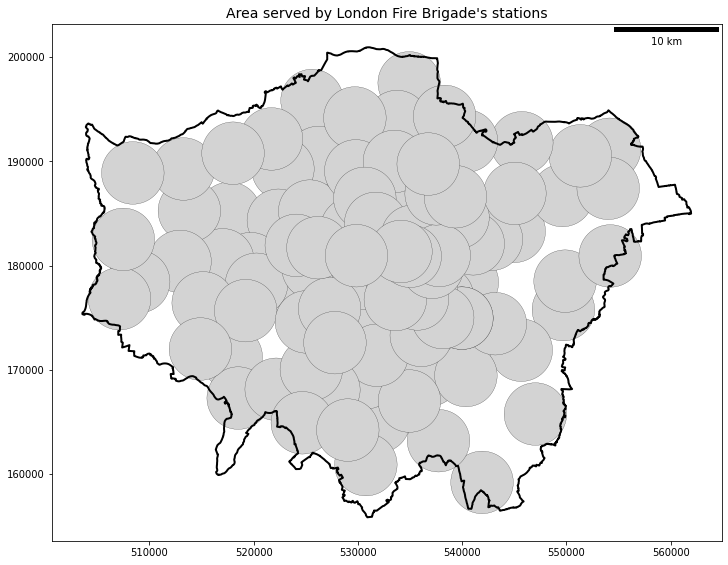

In [84]:
f, ax = plt.subplots(figsize=(12,10))
station_locations_3km_buffer.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth = 0.2)
london_boundary.plot(ax=ax, color='none', edgecolor = 'k', linewidth = 2)
ax.add_artist(ScaleBar(1))
plt.title("Area served by London Fire Brigade's stations", size = 14)

For ease of analysis we’re going to dissolve our polygons into one large polygon which represents the area served by the fire stations across London.

In [85]:
station_locations_3km_buffer = station_locations_3km_buffer.assign(group=1)

In [86]:
station_locations_3km_buffer_dissolve = station_locations_3km_buffer.dissolve(by = 'group')

And see how that differs from our previous layer…

Text(0.5, 1.0, "Area served by London Fire Brigade's stations")

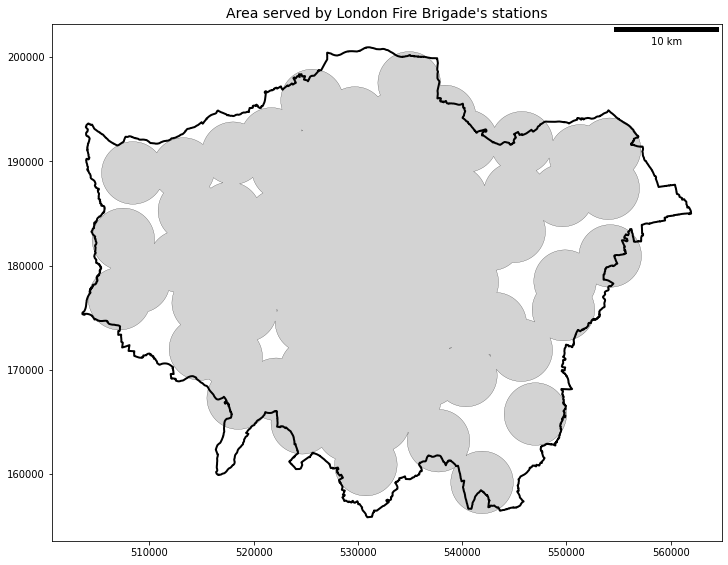

In [87]:
f, ax = plt.subplots(figsize=(12,10))
station_locations_3km_buffer_dissolve.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth = 0.2)
london_boundary.plot(ax=ax, color='none', edgecolor = 'k', linewidth = 2)
ax.add_artist(ScaleBar(1))
plt.title("Area served by London Fire Brigade's stations", size = 14)

Now let’s see which lost pets are not within 3km of a fire station.

We’ll use the **`.overlay()`** function on our GeoDataFrame. This function allows you tosee whether two objects touch, cross or overlap. In our case, we want to find instances where they do not touch so we will have to pass **difference** onto the **how** argument to achieve this.

In [88]:
uncovered_lost_pets = gpd.overlay(lost_pets_gdf, station_locations_3km_buffer, how='difference')

Text(0.5, 1.0, "Area served by London Fire Brigade's stations")

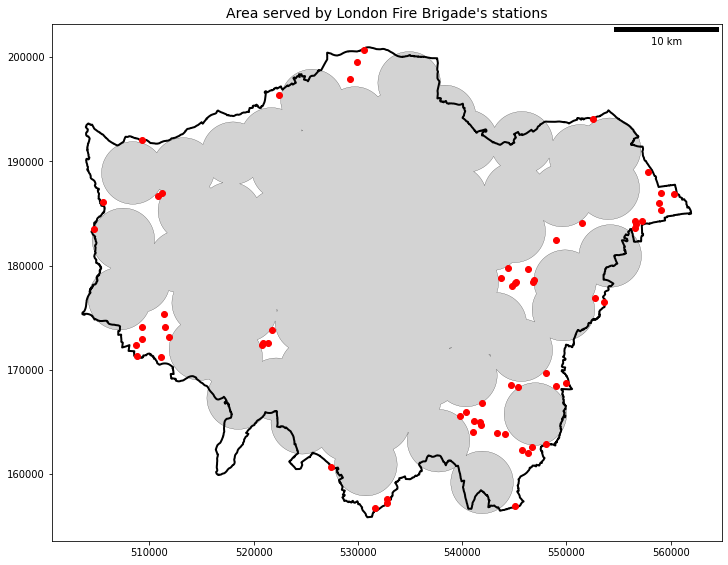

In [89]:
f, ax = plt.subplots(figsize=(12,10))
station_locations_3km_buffer_dissolve.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth = 0.2)
london_boundary.plot(ax=ax, color='none', edgecolor = 'k', linewidth = 2)
uncovered_lost_pets.plot(ax=ax, color='red')
ax.add_artist(ScaleBar(1))
plt.title("Area served by London Fire Brigade's stations", size = 14)

We can also calculate the distance from each point to the area covered by fire stations. 

In [90]:
def min_distance(point, polys):
    return polys.distance(point).min()

In [91]:
uncovered_lost_pets['min_dist_to_buffer'] = uncovered_lost_pets.geometry.apply(min_distance, args=(station_locations_3km_buffer_dissolve,))

In [92]:
uncovered_lost_pets.head()

,id,easting,northing,ctyua19cd,ctyua19nm,animal,pet_found,geometry,min_dist_to_buffer
0,8,546280,161974,E09000006,Bromley,dog,yes,POINT (546280.000 161974.000),853.781815
1,12,560331,186889,E09000016,Havering,hamster,yes,POINT (560331.000 186889.000),3348.146343
2,31,559039,186941,E09000016,Havering,dog,no,POINT (559039.000 186941.000),2055.903033
3,34,556651,183947,E09000016,Havering,cat,yes,POINT (556651.000 183947.000),898.410823
4,39,557804,188953,E09000016,Havering,dog,yes,POINT (557804.000 188953.000),1100.661946


Calculate the mean distance to the fire station service area:

In [93]:
mean = uncovered_lost_pets.min_dist_to_buffer.mean()

In [94]:
mean

849.8720223220828

# Improving this analysis using Network Analysis
The problem with all of the analysis we’ve completed so far is that is uses straight lines to calculate distances (Euclidean distance). In reality, a fire engine would be driving along a road network to get to an incident, so we should use that to calculate our distances. Barriers to travel networks, like motorways or rivers, can be very influential in differences between Euclidean distance and network distance. Luckily, we can calculate network distances with network analysis.

We’re not going to dive into this in any detail during this exercise but we wanted to introduce the technique. Here’s an example of our 3km buffer calculated using network analysis instead of a buffer.

# Final Exercise
You have now seen more examples of spatial data wrangling, geospatial operations and analysis techniques, and methods of mapping. By adding this knowledge to your existing experience using Python and Geopandas packages you can now do a wide range of analysis.

For the remainder of the session try using the data provided to extend your analysis and produce a short report (Jupyter Notebook perhaps?) or presentation illustrating your findings. You have all three datasets to utilise so think about how you can bring them together to answer some pertinent questions. Here are some ideas to get you started:

* Filtering incidents which are covered by two or more stations, also mapping them
* Filter incidents which aren’t covered by a fire station
* Cutting buffered service area out of London LA to map areas which aren’t covered
* assessing whether there’s any link between the number of fire stations which cover an area and the number of animal related incidents
* is there a link between cost of incidents and number of reported lost pets?

Feel free to pair program or work individually - this is open time for you to cement and extend your skills in the best way for you.

At the end of the session we will dedicate time to reviewing the work done by others so we can learn from each other. There will be instructors on hand to support you if needed - please just ask.

# Reminders

You can export your maps using plt.savefig.